# Topic modeling with BERTopic

In this notebook, BERTopic is implemented with word2vec embedding

In [1]:
pip install bertopic

In [2]:
from gensim.models import Word2Vec
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords
import nltk
import re
from gensim import corpora
from gensim.models.coherencemodel import CoherenceModel

Loading processed dataset as described in the preprocessing notebook and the word2vec model

In [3]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Load Word2Vec model and dataset
word2vec_model_path = "/content/drive/MyDrive/word2vec_model.model"
word2vec_model = Word2Vec.load(word2vec_model_path)
data_path = "/content/drive/MyDrive/train_df_TM.csv"
train_df = pd.read_csv(data_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Preliminary steps before optimizing the model

In [4]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def clean_text(text):
    tokens = text.split()
    return [word.lower() for word in tokens if word.lower() not in stop_words]

texts = [clean_text(text) for text in train_df['lemmatized']]
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]
documents = [" ".join(text) for text in texts]

def compute_coherence_with_gensim(topic_model, texts, dictionary, coherence_type="c_v"):
    topics = topic_model.get_topics()
    tokenized_topics = [[word for word, _ in words] for topic_id, words in topics.items() if topic_id != -1]
    coherence_model = CoherenceModel(
        topics=tokenized_topics,
        texts=texts,
        dictionary=dictionary,
        coherence=coherence_type
    )
    return coherence_model.get_coherence()

def compute_topic_diversity(topic_model, top_n_words=10):
    topics = topic_model.get_topics()
    all_words = set()
    unique_words = set()
    for topic_id, words in topics.items():
        if topic_id == -1:  # Ignore outlier topic
            continue
        top_words = [word for word, _ in words[:top_n_words]]
        unique_words.update(top_words)
        all_words.update(top_words)
    return len(unique_words) / (len(all_words) * len(topics)) if all_words else 0

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Evaluating the different number of topics in terms of C_V performance. This results are compared with LDA to identify the better performance among the two models.

In [5]:
num_topics_list = [4, 6, 8, 10, 12]
results = []

for num_topics in num_topics_list:
    topic_model = BERTopic(embedding_model=word2vec_model.wv, nr_topics=num_topics)
    topics, _ = topic_model.fit_transform(documents)
    coherence = compute_coherence_with_gensim(topic_model, texts, dictionary, coherence_type="c_v")
    diversity = compute_topic_diversity(topic_model)
    results.append({
        "num_topics": num_topics,
        "coherence": coherence,
        "diversity": diversity,
        "model": topic_model
    })

for result in results:
    print(f"Num Topics: {result['num_topics']}, Coherence: {result['coherence']}, Diversity: {result['diversity']}")

coherence_scores = [res['coherence'] for res in results]
diversity_scores = [res['diversity'] for res in results]
num_topics_list = [res['num_topics'] for res in results]

Num Topics: 4, Coherence: 0.3404928049003669, Diversity: 0.25
Num Topics: 6, Coherence: 0.3313142476330088, Diversity: 0.16666666666666666
Num Topics: 8, Coherence: 0.3395239262795405, Diversity: 0.125
Num Topics: 10, Coherence: 0.3455420954375922, Diversity: 0.1
Num Topics: 12, Coherence: 0.33441035280041403, Diversity: 0.08333333333333333


Plot of the results

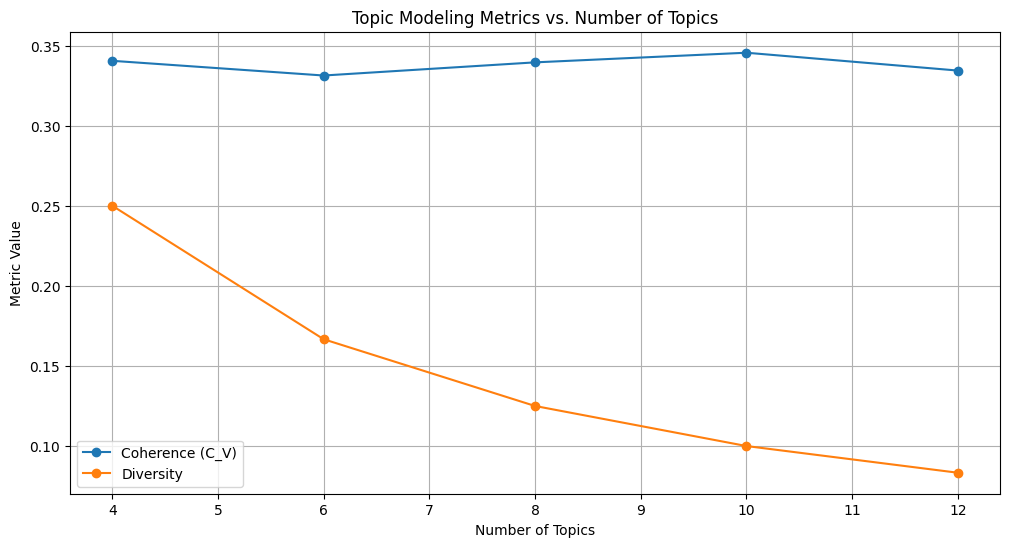

In [6]:
plt.figure(figsize=(12, 6))
plt.plot(num_topics_list, coherence_scores, label='Coherence (C_V)', marker='o')
plt.plot(num_topics_list, diversity_scores, label='Diversity', marker='o')
plt.xlabel('Number of Topics')
plt.ylabel('Metric Value')
plt.title('Topic Modeling Metrics vs. Number of Topics')
plt.legend()
plt.grid()
plt.show()

Word clouds for the best value of k (number of topics)

Final C_V coherence score for the best model: 0.3455420954375922


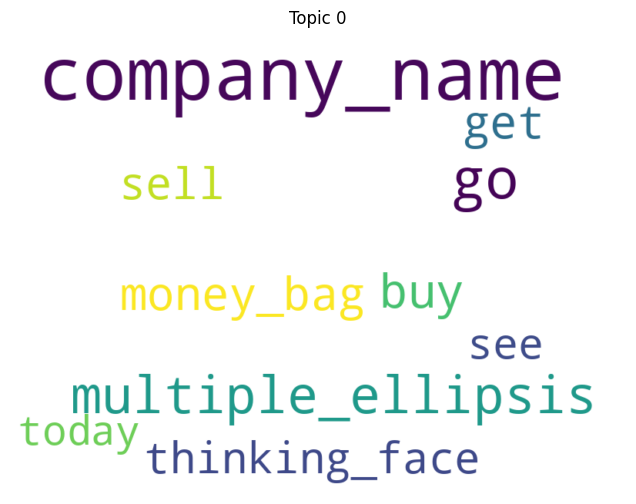

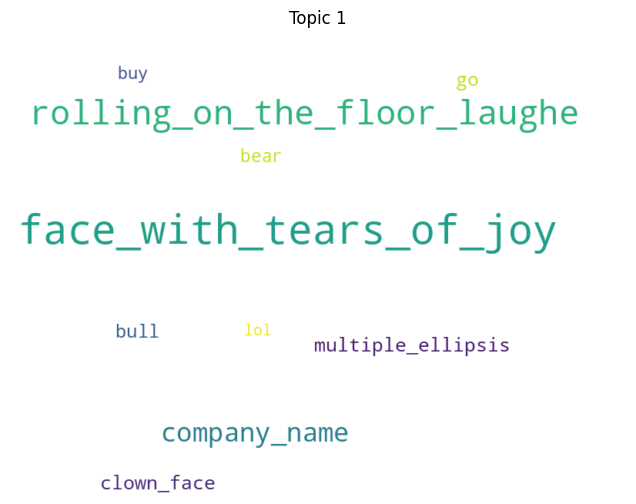

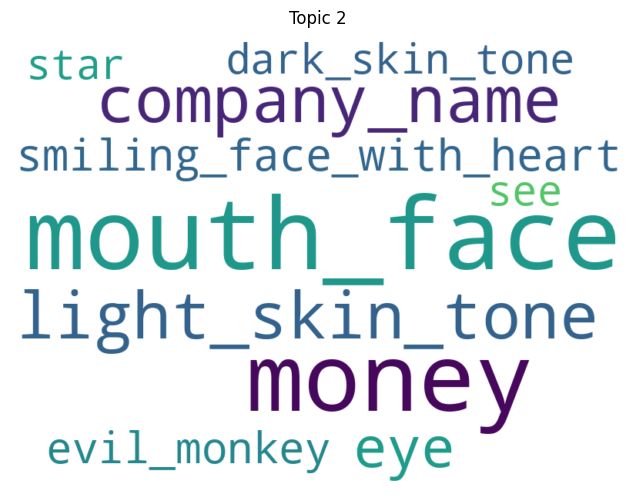

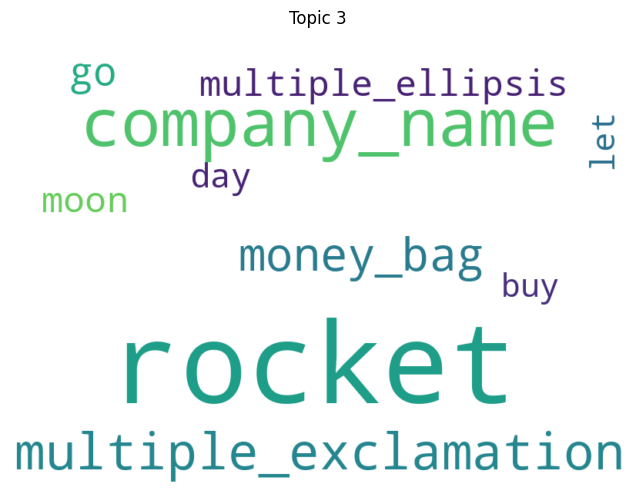

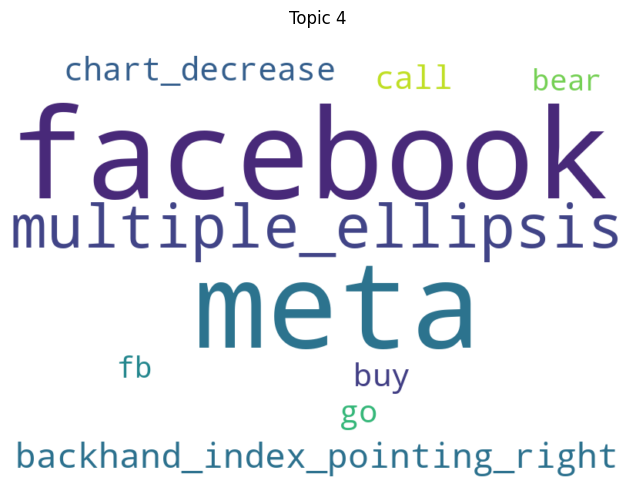

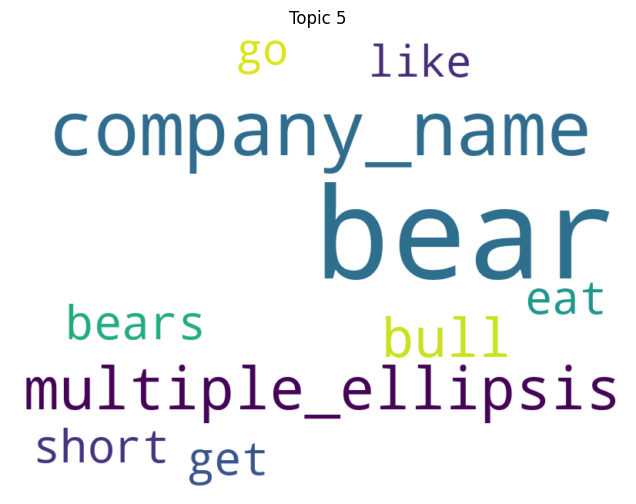

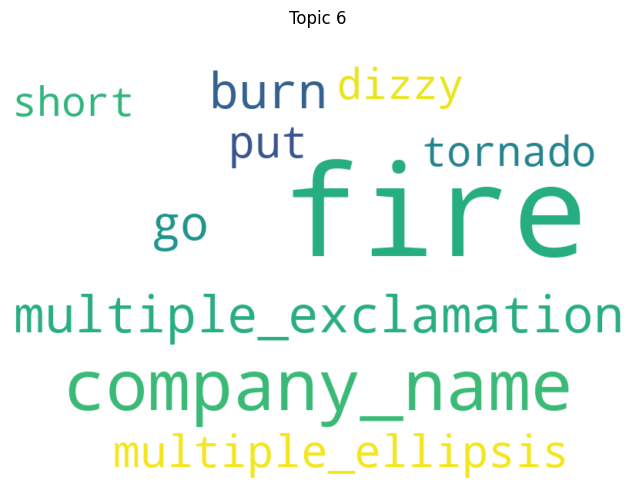

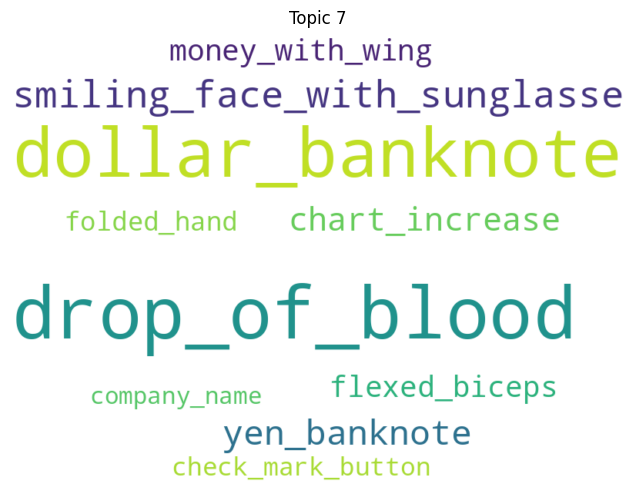

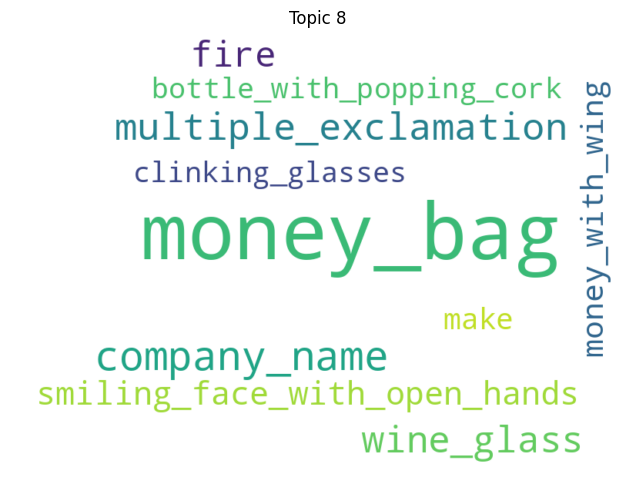

In [7]:
best_model_index = np.argmax(coherence_scores)
best_topic_model = results[best_model_index]['model']

def compute_and_display_cv(best_topic_model, texts, dictionary):
    tokenized_topics = [[word for word, _ in words] for topic_id, words in best_topic_model.get_topics().items() if topic_id != -1]
    coherence_model_cv = CoherenceModel(
        topics=tokenized_topics,
        texts=texts,
        dictionary=dictionary,
        coherence="c_v"
    )
    cv_coherence_score = coherence_model_cv.get_coherence()
    print(f"Final C_V coherence score for the best model: {cv_coherence_score}")
    return cv_coherence_score

final_cv_score = compute_and_display_cv(best_topic_model, texts, dictionary)

def plot_individual_wordclouds(topic_model, min_weight=0.01):
    topics = topic_model.get_topics()
    filtered_topics = {k: v for k, v in topics.items() if k != -1}
    for topic_id, words in filtered_topics.items():
        word_freq = {word: weight for word, weight in words if weight >= min_weight}
        if not word_freq:
            print(f"Topic {topic_id} has no significant words to display.")
            continue
        wordcloud = WordCloud(width=800, height=600, background_color='white').generate_from_frequencies(word_freq)
        plt.figure(figsize=(8, 6), dpi=100)
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f"Topic {topic_id}")
        plt.show()

plot_individual_wordclouds(best_topic_model, min_weight=0.01)

In order to look for possible associations, the word clouds corresponding to the emotions are also plot.

In [8]:
train_df

,emo_label,senti_label,original,processed,tfidf_emoji,tfidf_demojized,tfidf_no_emoji,lemmatized
0,excitement,bullish,$AMZN Dow futures up by 100 points already 🥳,Amazon Dow futures up by 100 points already [...,company_name Dow futures up by 100 points alre...,company_name Dow futures up by 100 points alre...,company_name Dow futures up by 100 points already,company_name Dow future up by 100 point alread...
1,excitement,bullish,$TSLA Daddy's drinkin' eArly tonight! Here's t...,Tesla Daddy's drinkin' eArly tonight! Here's t...,company_name Daddy's drinkin' eArly tonight! H...,company_name Daddy's drinkin' eArly tonight! H...,company_name Daddy's drinkin' eArly tonight! H...,company_name daddy 's drinkin ' early tonight ...
2,confusion,bullish,$AAPL We’ll been riding since last December fr...,Apple We’ll been riding since last December fr...,company_name We’ll been riding since last Dece...,company_name We’ll been riding since last Dece...,company_name We’ll been riding since last Dece...,company_name we ’ll be ride since last Decembe...
3,excitement,bullish,"$TSLA happy new year, 2020, everyone🍷🎉🙏","Tesla happy new year, 2020, everyone [wine gla...",company_name happy new year 2020 everyone🍷🎉🙏,company_name happy new year 2020 everyone wine...,company_name happy new year 2020 everyone,company_name happy new year 2020 everyone wine...
4,excitement,bullish,"$TSLA haha just a collection of greats...""Mars...","Tesla haha just a collection of greats...""Mars...",company_name haha just a collection of greats ...,company_name haha just a collection of greats ...,company_name haha just a collection of greats ...,company_name haha just a collection of great m...
...,...,...,...,...,...,...,...,...
7995,surprise,bullish,BREAKING NEWS: $AAPL beats Elon Musk and Richa...,BREAKING NEWS: Apple beats Elon Musk and Richa...,BREAKING NEWS company_name beats Elon Musk and...,BREAKING NEWS company_name beats Elon Musk and...,BREAKING NEWS company_name beats Elon Musk and...,break news company_name beat Elon Musk and Ric...
7996,belief,bullish,$AAPL why be a 2T giant and not dabble a littl...,Apple why be a 2T giant and not dabble a littl...,company_name why be a 2T giant and not dabble ...,company_name why be a 2T giant and not dabble ...,company_name why be a 2T giant and not dabble ...,company_name why be a 2 t giant and not dabble...
7997,ambiguous,bullish,"$AMZN - 3,500 jobs = $3,500 ??? 😁","Amazon - 3,500 jobs = $3,500 ??? [beaming fac...",company_name - 3500 jobs = $3500 multiple_ques...,company_name - 3500 jobs = $3500 multiple_ques...,company_name - 3500 jobs = $3500 multiple_ques...,company_name - 3500 job = $ 3500 multiple_ques...
7998,surprise,bullish,$TSLA $500c 10/2 at 36k volume 👀👀,Tesla $500c 10/2 at 36k volume [eyes],company_name $500c 10/2 at 36k volume 👀👀,company_name $500c 10/2 at 36k volume eyes eyes,company_name $500c 10/2 at 36k volume,company_name $ 500c 10/2 at 36k volume eye eye


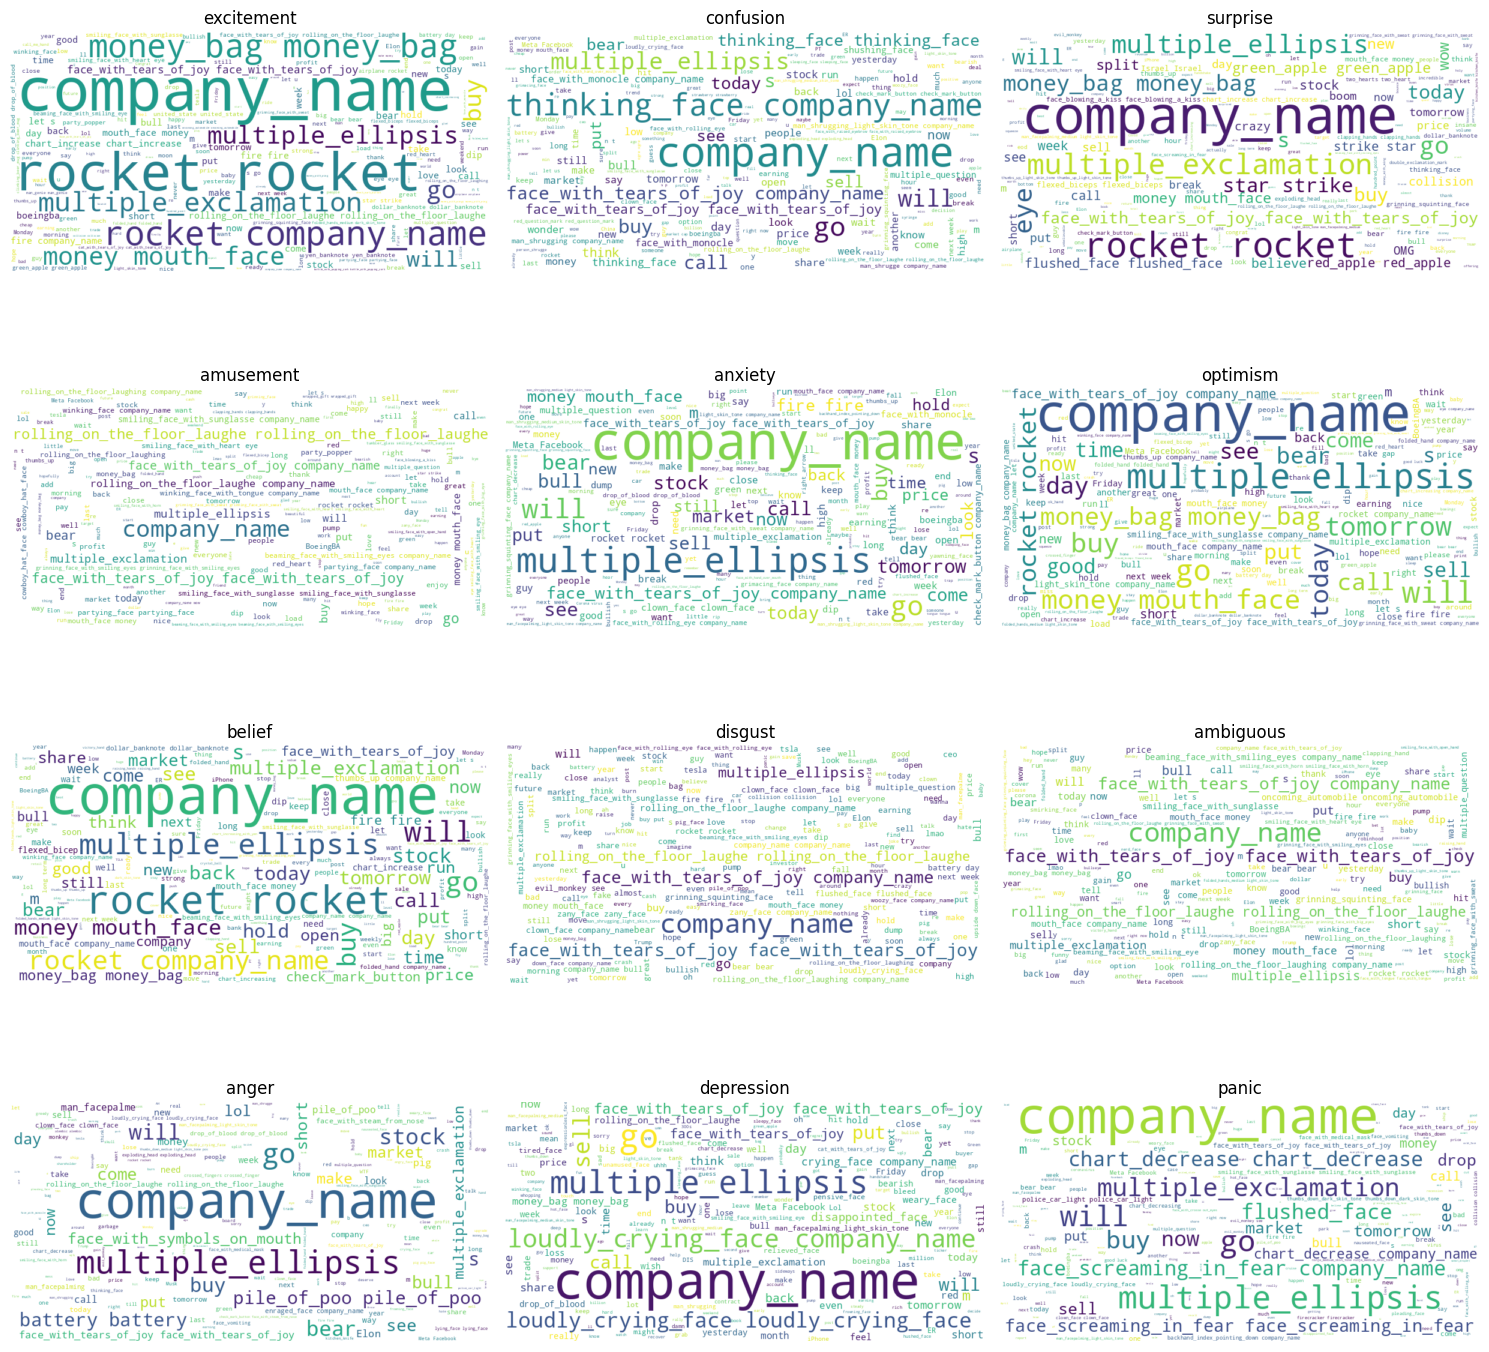

In [9]:
grouped = train_df.groupby('emo_label')['lemmatized'].apply(' '.join)
plt.figure(figsize=(15, 15))
unique_labels = train_df['emo_label'].unique()

for i, label in enumerate(unique_labels):
    plt.subplot(4, 3, i + 1)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(grouped[label])
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(label)
    plt.axis('off')

plt.tight_layout()
plt.show()